In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
# target = "target_close"
# target = "close_percent_change_1"
target = "up_down_close_1"

In [3]:
# Load model
# model = pickle.load(open("../model/xgboost_model.pkl", "rb"))

try:
    model = xgb.XGBRegressor()
    model.load_model("../model/xgboost_model.json")
except:
    model = xgb.XGBClassifier()
    model.load_model("../model/xgboost_model.json")

In [4]:
# print features name
print(len(model.get_booster().feature_names))
model.get_booster().get_score()

316


{'close': 21.0,
 'high': 10.0,
 'low': 8.0,
 'open': 12.0,
 'volume': 57.0,
 'volitility_open_7': 78.0,
 'volitility_pct_change_7_open': 153.0,
 'high_low_7': 102.0,
 'high_close_7': 161.0,
 'low_close_7': 153.0,
 'true_range_7': 63.0,
 'average_true_range_7': 36.0,
 'open_rolling_mean_7': 2.0,
 'open_rolling_exp_mean_7': 4.0,
 'rsi_7': 167.0,
 'short_ema_12': 26.0,
 'long_ema_26': 25.0,
 'macd_12_26': 104.0,
 'signal_9': 64.0,
 'macd_hist_12_26_9': 136.0,
 'stochastic_oscillator_7': 150.0,
 'williams_r_7': 139.0,
 'on_balance_volume_1': 92.0,
 'volume_weighted_average_price_7': 8.0,
 'open_rolling_std_7': 39.0,
 'open_bollinger_upper_7': 4.0,
 'open_bollinger_lower_7': 5.0,
 'volitility_open_14': 43.0,
 'volitility_pct_change_14_open': 91.0,
 'high_low_14': 38.0,
 'high_close_14': 89.0,
 'low_close_14': 66.0,
 'true_range_14': 50.0,
 'average_true_range_14': 31.0,
 'open_rolling_mean_14': 4.0,
 'open_rolling_exp_mean_14': 4.0,
 'rsi_14': 186.0,
 'stochastic_oscillator_14': 138.0,
 'wi

In [5]:
# load predictions
df = pd.read_parquet("../data/predicted.parquet")

In [6]:
def normalize_column(data: pd.DataFrame, column: str | list) -> pd.DataFrame:
    if isinstance(column, str):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    elif isinstance(column, list):
        for col in column:
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

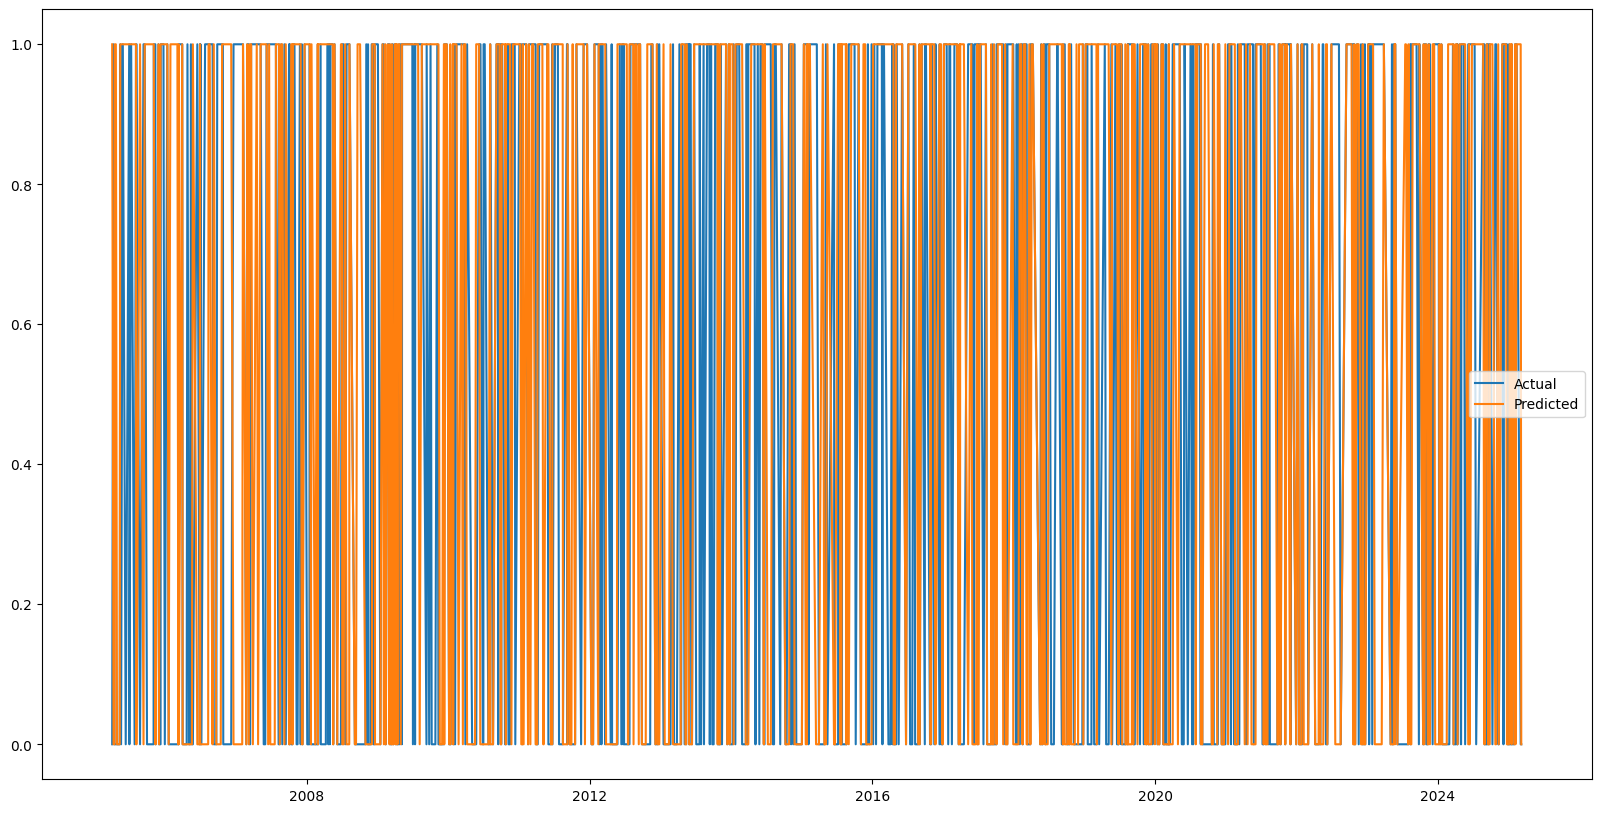

In [7]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(df[target], label="Actual")
plt.plot(df["predicted"], label="Predicted")
plt.legend()
plt.show()

<Axes: xlabel='date', ylabel='value'>

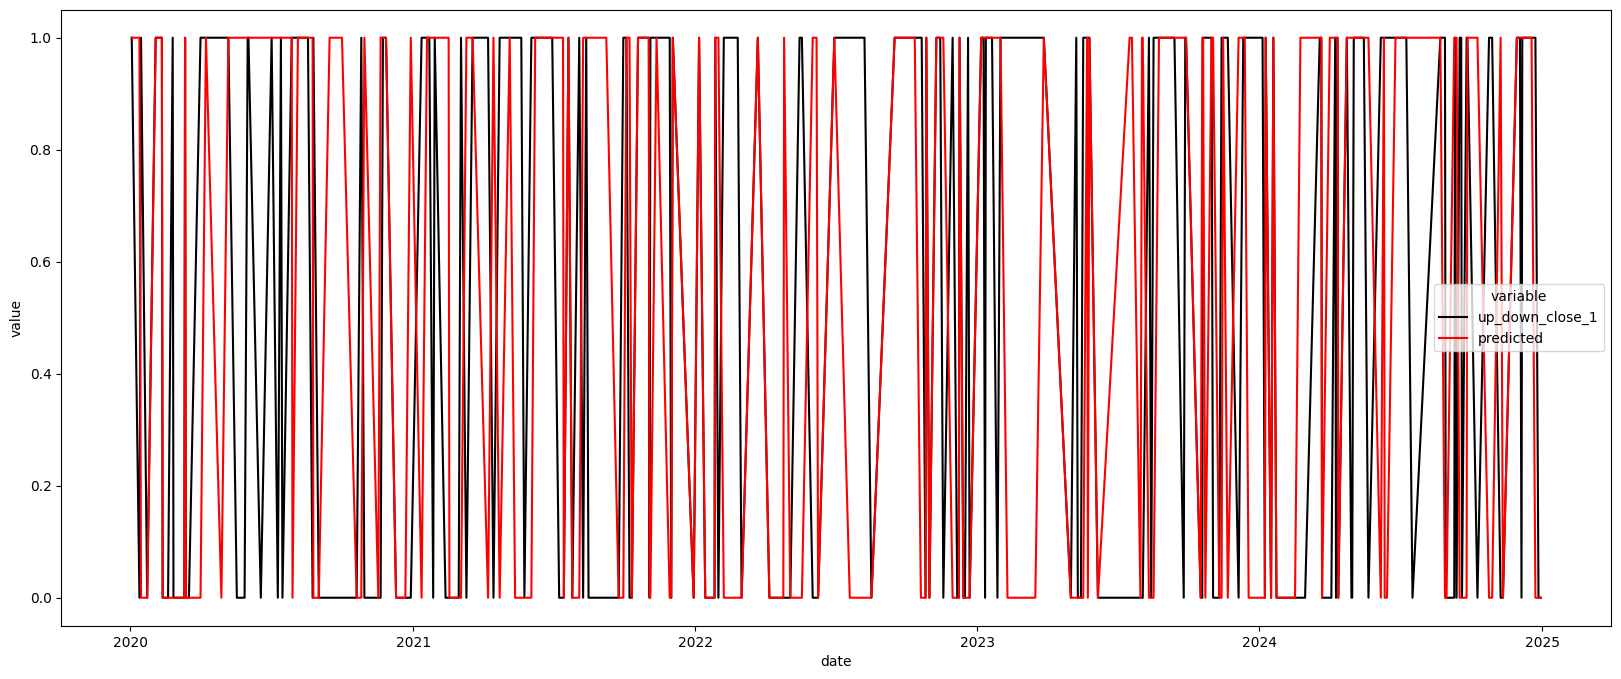

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))
# Only 2008 - 2012 indexs 
df_date = df.loc["2020":"2024"]

sns.lineplot(
    df_date.reset_index().melt(id_vars=["date"], value_vars=[target, "predicted"]),
    y="value",
    x="date",
    hue="variable",
    linewidth=1.5,
    palette=['black', 'red'],
    ax=ax,
)

In [9]:
df_importance = pd.DataFrame()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]
for importance_type in importance_types:
    importance = model.get_booster().get_score(importance_type=importance_type)

    df_i = pd.DataFrame(importance.items(), columns=["feature", importance_type])

    if df_importance.empty:
        df_importance = df_i
    else:
        df_importance = pd.merge(df_importance, df_i, on="feature", how="outer")
df_importance


,feature,weight,gain,cover,total_gain,total_cover
0,average_true_range_14,31.0,3.614465,138.016891,112.048431,4278.523438
1,average_true_range_30,26.0,4.353745,123.148491,113.197380,3201.860840
2,average_true_range_7,36.0,3.024745,104.215874,108.890823,3751.771484
3,close,21.0,2.912969,123.059311,61.172352,2584.245605
4,close_bollinger_lower_14,5.0,3.871613,12.274076,19.358067,61.370380
...,...,...,...,...,...,...
292,volume_weighted_average_price_7,8.0,1.843790,5.579602,14.750321,44.636814
293,week_of_year,66.0,3.396610,235.925018,224.176254,15571.050781
294,williams_r_14,74.0,3.104643,133.944931,229.743561,9911.924805
295,williams_r_30,84.0,3.160395,98.467575,265.473175,8271.276367


In [10]:
df_importance = normalize_column(df_importance, ["weight", "gain", "cover", "total_gain", "total_cover"])
df_importance_melted = df_importance.sort_values(by="weight", ascending=True).melt(id_vars=["feature"], value_vars=importance_types)
df_importance_melted

,feature,variable,value
0,close_rolling_exp_mean_7,weight,0.000000
1,close_lag_7,weight,0.000000
2,high_bollinger_upper_7,weight,0.000000
3,high_lag_19,weight,0.000000
4,high_lag_10,weight,0.000000
...,...,...,...
1480,low_close_7,total_cover,0.561019
1481,rsi_30,total_cover,0.801566
1482,high_close_7,total_cover,0.646716
1483,rsi_7,total_cover,0.478692


<Axes: xlabel='value', ylabel='feature'>

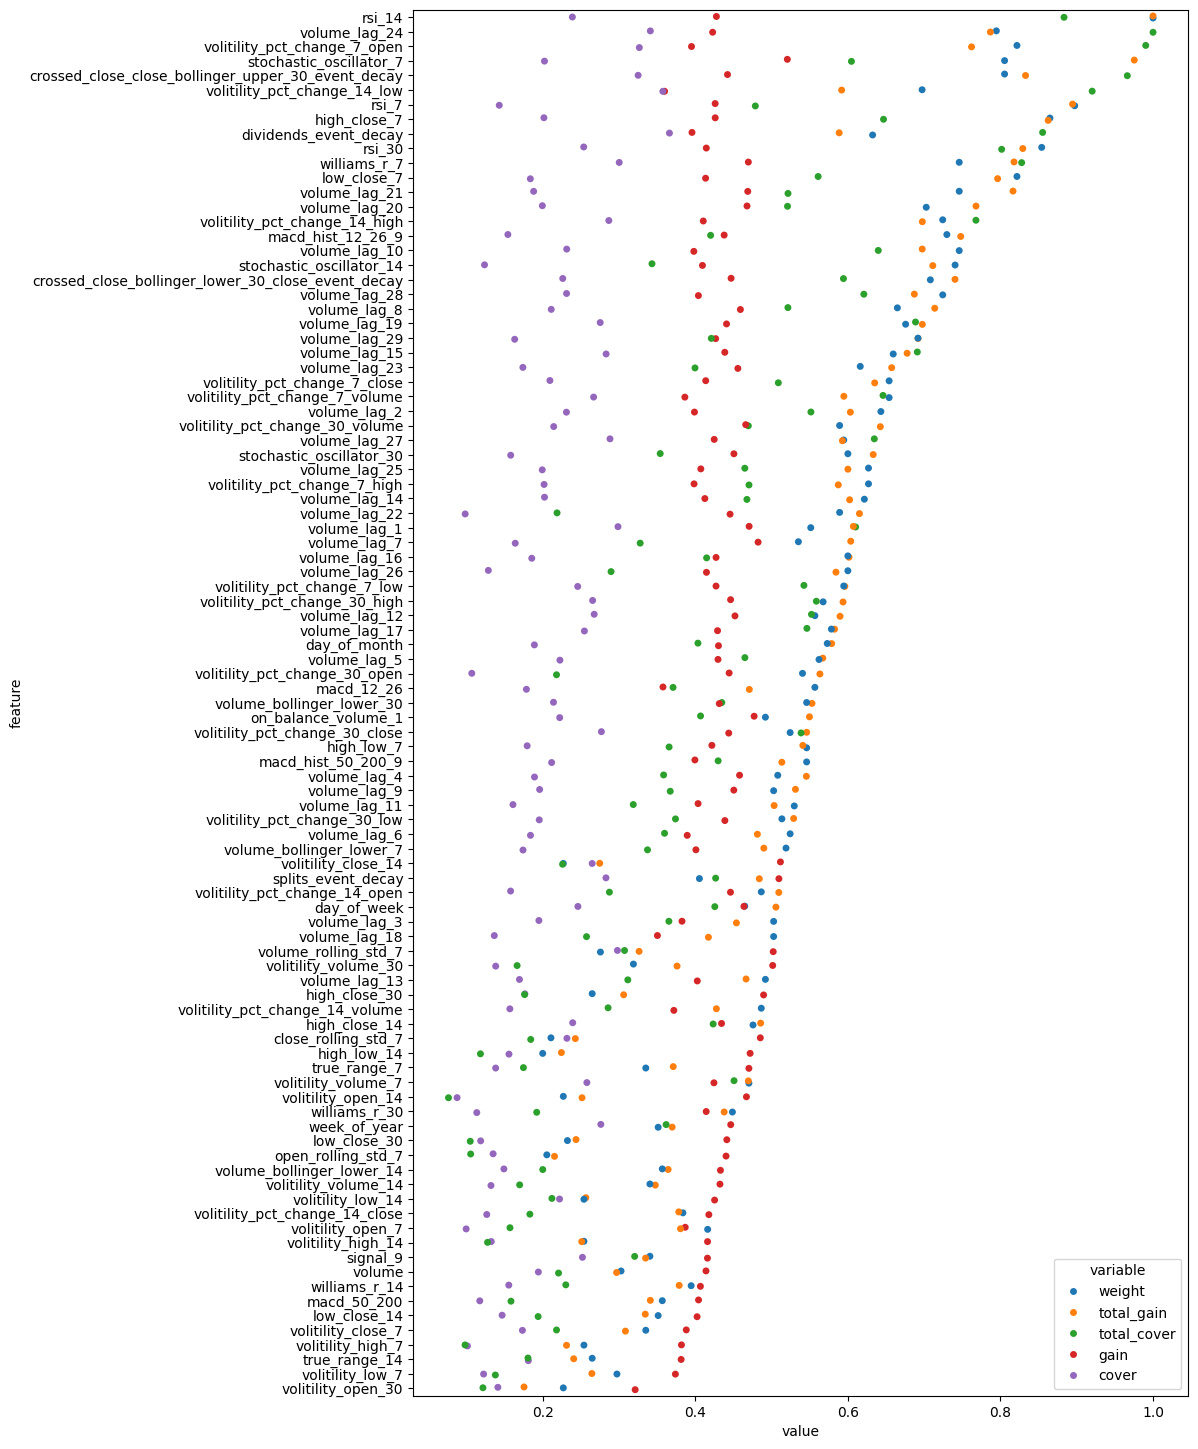

In [11]:
fig, ax = plt.subplots(figsize=(10, 18))
sns.stripplot(
    df_importance[df_importance["weight"] >= 0.2]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
    jitter=True,
    legend="auto",
)

<Axes: xlabel='value', ylabel='feature'>

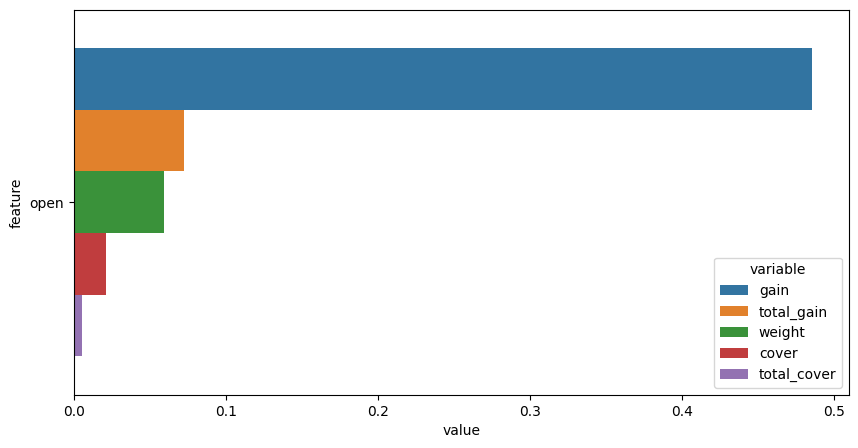

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_importance[df_importance["feature"] == "open"]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

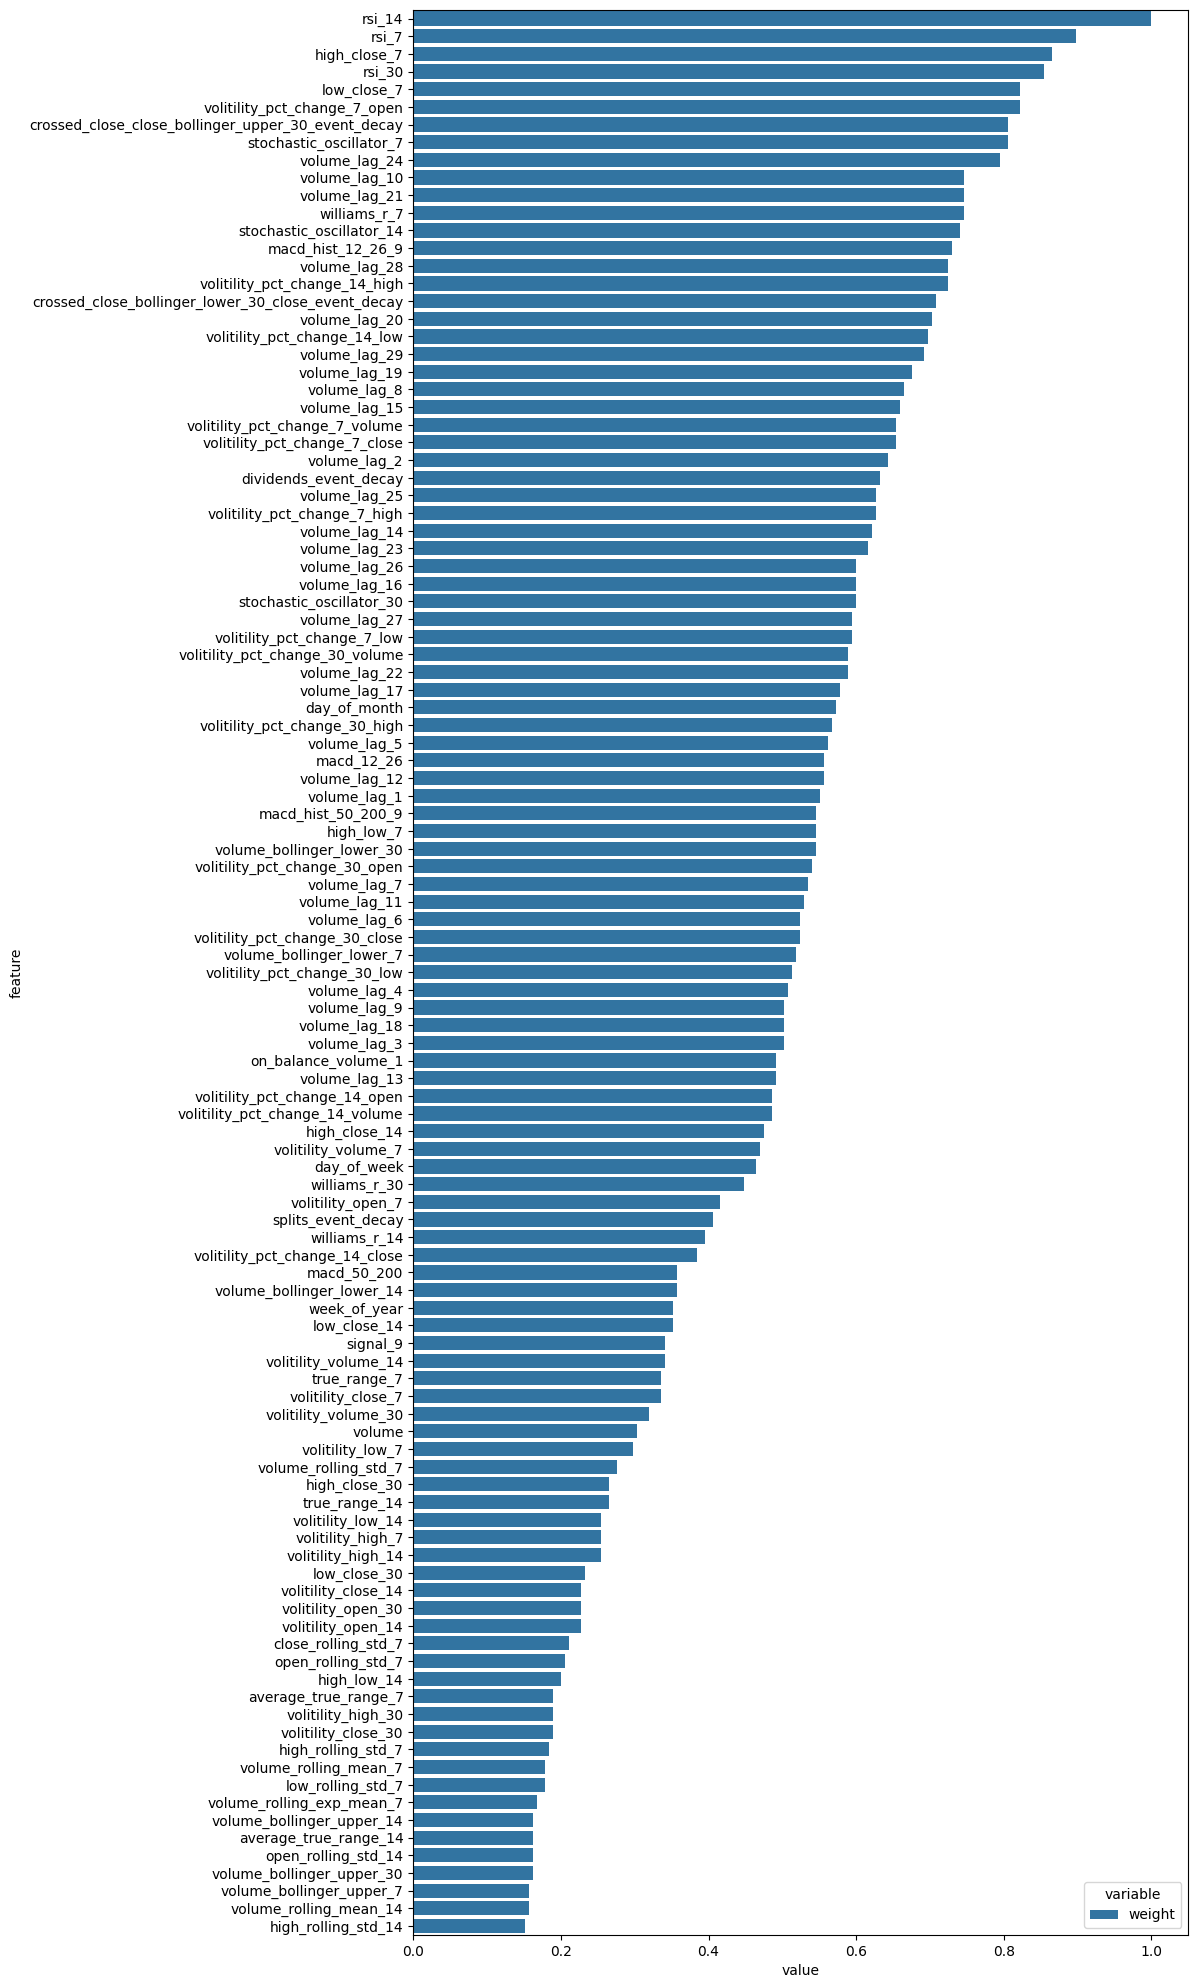

In [13]:
fig, ax = plt.subplots(figsize=(10, 25))
sns.barplot(
    df_importance[df_importance["weight"] >= 0.15][["feature", "weight"]]
    .melt(id_vars=["feature"], value_vars=["weight"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

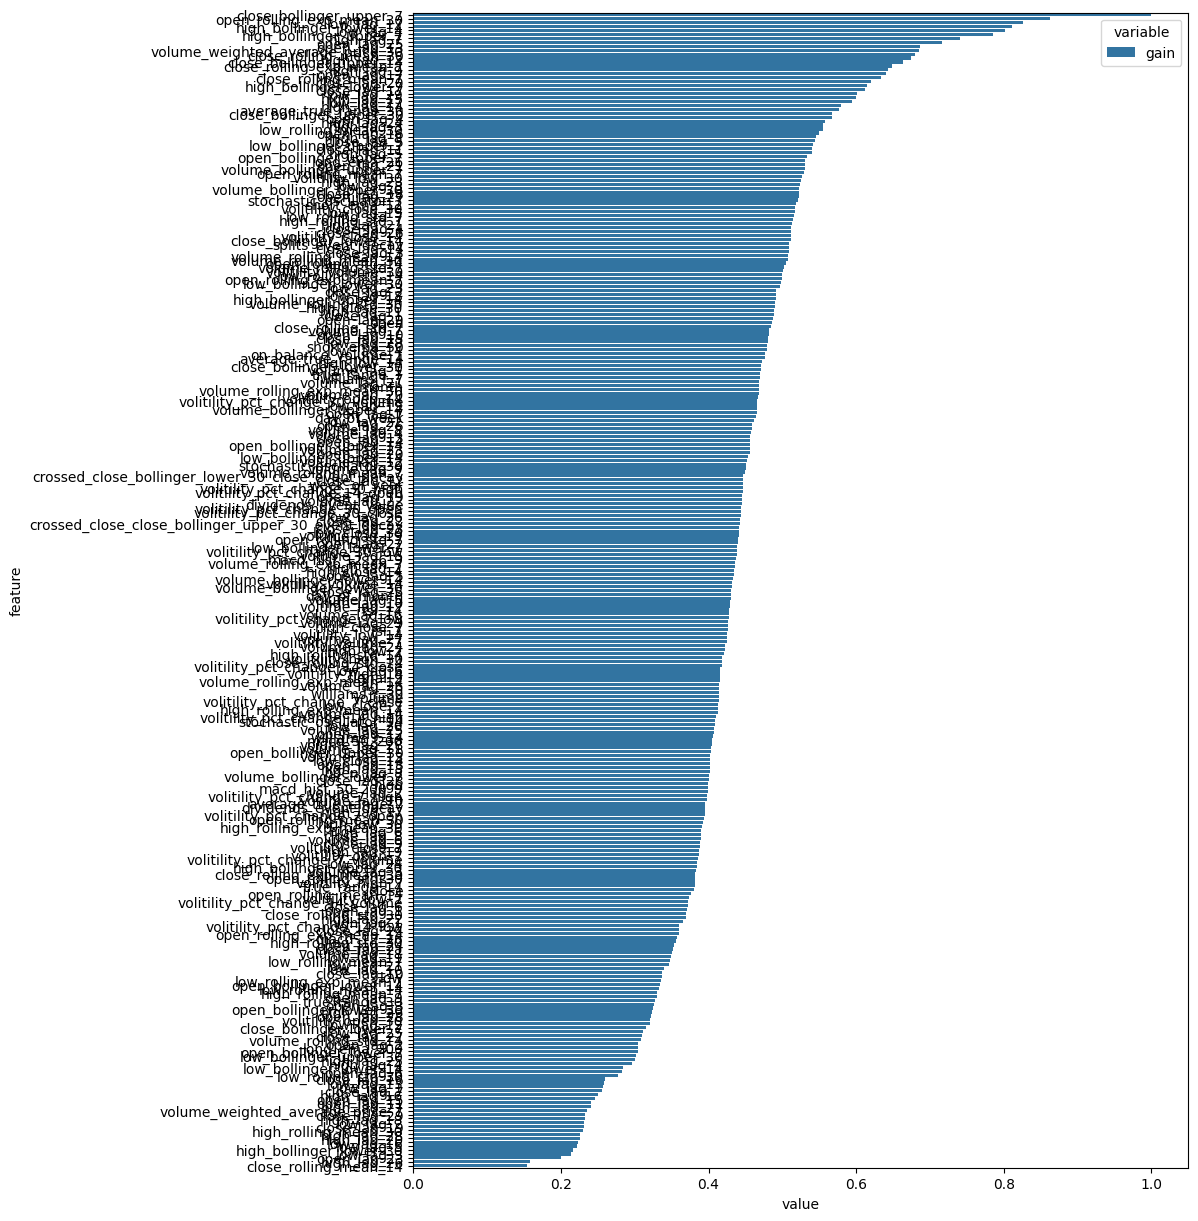

In [14]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(
    df_importance[df_importance["gain"] >= 0.15][["feature", "gain"]]
    .melt(id_vars=["feature"], value_vars=["gain"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

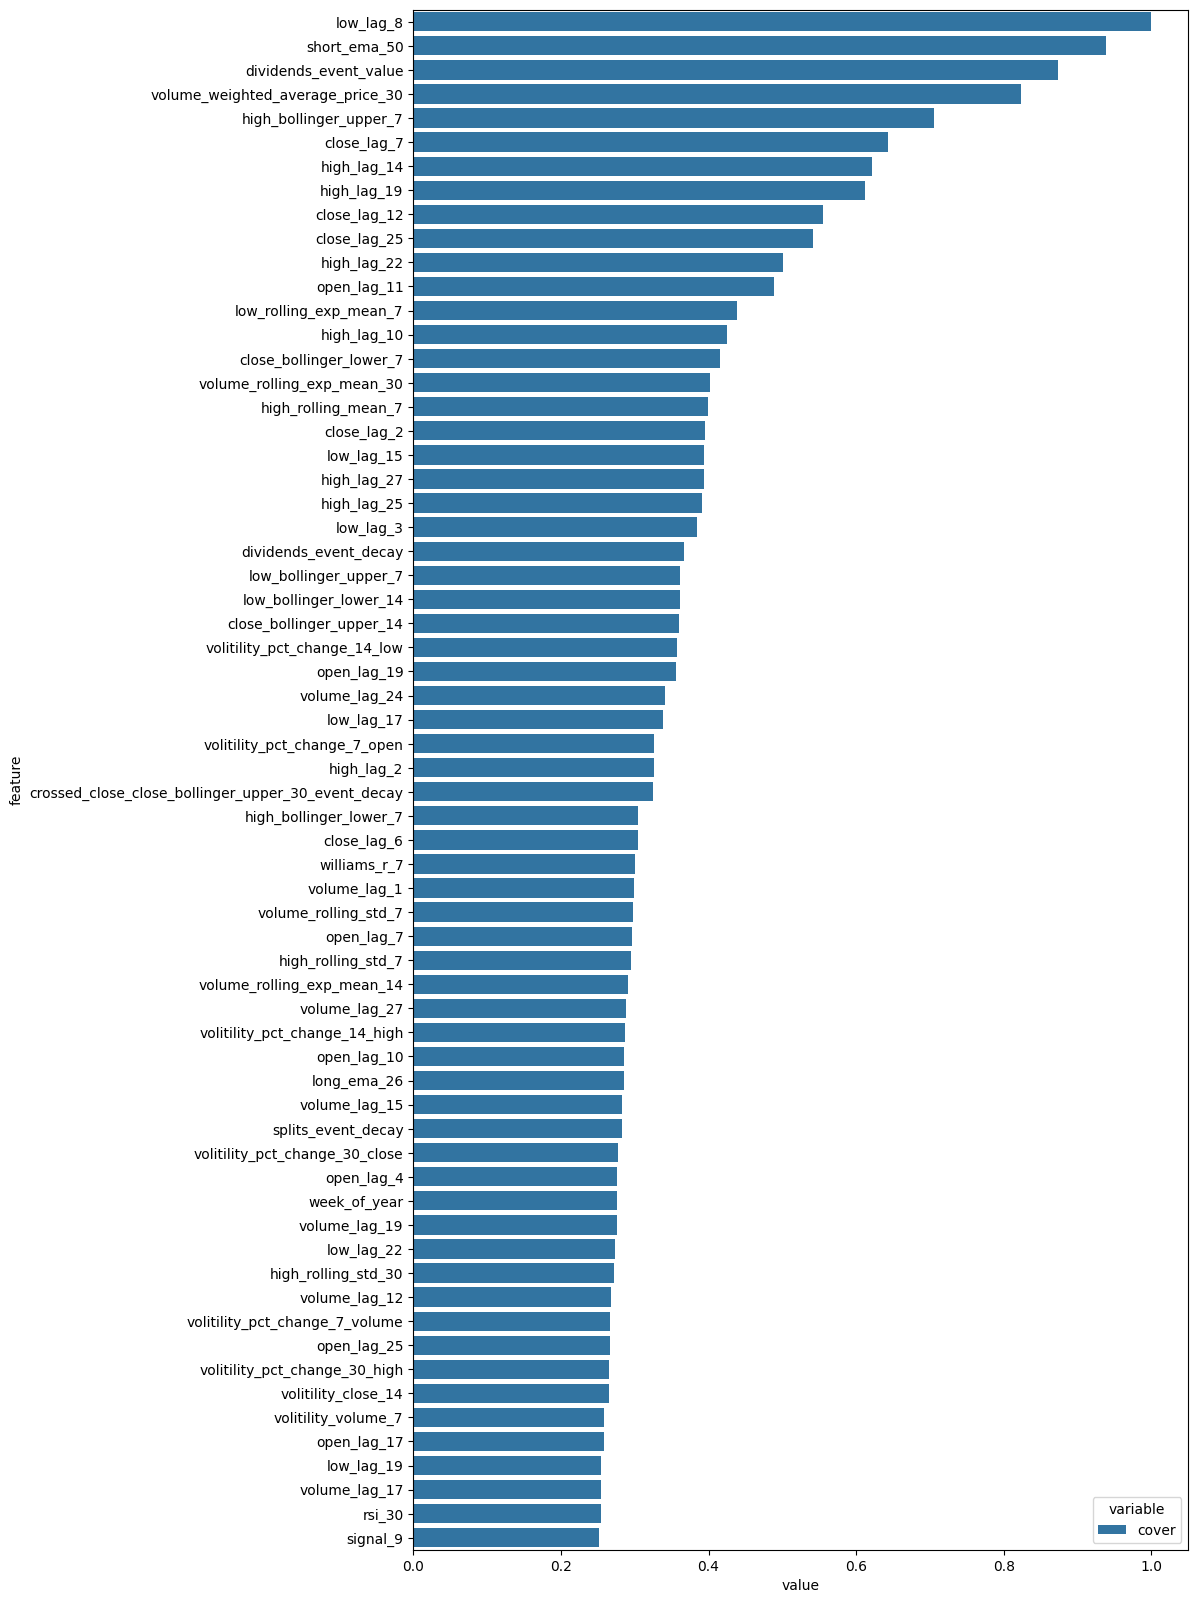

In [15]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.barplot(
    df_importance[df_importance["cover"] >= 0.25][["feature", "cover"]]
    .melt(id_vars=["feature"], value_vars=["cover"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)